In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir, sys
from os.path import isfile, join
import tensorflow as tf
from scipy import stats
import time
from imp import reload

%matplotlib inline

In [2]:
read_file_path = "/home/ch194765/repos/atlas-active-learning/"

sys.path.insert(0, read_file_path)
import prep_dat

import NNAL
import NNAL_tools

# Playing with TF Gradients

In [506]:
# input
X = tf.placeholder("float", [3, None])
y = tf.placeholder("float", [2, None])

# layer one
W_1 = tf.Variable(tf.ones([3,3]))
b_1 = tf.Variable(tf.zeros([3,1]))
z_1 = tf.add(tf.matmul(W_1, X), b_1)
a_1 = tf.nn.sigmoid(z_1)

# layer two (last layer)
W_2 = tf.Variable(tf.ones([2,3]))
b_2 = tf.Variable(tf.zeros([2,1]))
z_2 = tf.add(tf.matmul(W_2, a_1), b_2)
a_2 = tf.sigmoid(z_2)   # (output)

# loss function
J = tf.multiply(tf.reduce_sum(tf.pow(tf.subtract(y, a_2), 2)), .5)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


In [3]:
Xin = np.array([[1., 0.], [0., 1.], [0., 0.]])
yin = np.array([[1., 0.], [0., 1.]])
grad_vals = tf.gradients(J, [W_1, b_1, W_2, b_2])
sess.run(grad_vals, feed_dict={X:Xin, y:yin})

[array([[ 0.014189,  0.014189,  0.      ],
        [ 0.014189,  0.014189,  0.      ],
        [ 0.014189,  0.014189,  0.      ]], dtype=float32),
 array([[ 0.02837801],
        [ 0.02837801],
        [ 0.02837801]], dtype=float32),
 array([[ 0.05275872,  0.05275872,  0.05275872],
        [ 0.05275872,  0.05275872,  0.05275872]], dtype=float32),
 array([[ 0.07216756],
        [ 0.07216756]], dtype=float32)]

In [ ]:
optimizer = tf.train.GradientDescentOptimizer(56)
G = optimizer.compute_gradients(J, [W_1, b_1, W_2, b_2])
Gs = sess.run(G, feed_dict={X:Xin, y:yin})
#Gs

# Try Some Active Learning on an MNIST Example

In [4]:
# load the data from TF 
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Here, we don't use all the training data of the `mnist` object since we need to leave some part of the training unlabeled to do querying. Hence, we manually take a portion of the training as the initial labeled data set, and use the rest for evaluating our active learning method.

In [1056]:
reload(prep_dat)
reload(NNAL_tools)
# number of the initial labeled data set
init_size = 200
batch_size = 50
epochs = 100

batch_of_data, batch_of_labels, pool_images, pool_labels, test_images, test_labels = \
    NNAL_tools.init_MNIST(init_size, batch_size)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Now, use the initial training data set to train a simple NN over the data using cross-entropy or any other loss function. 

In [1057]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

#batch_of_data = fi_data
#batch_of_labels = fi_labels

# input and output placeholders
x = tf.placeholder(tf.float32, shape=[784, None])
y_ = tf.placeholder(tf.float32, shape=[10, None])

# parameters
W = tf.Variable(tf.zeros([10, 784]))
b = tf.Variable(tf.zeros([10,1]))
sess.run(tf.global_variables_initializer())

# output should be a normalized 
y = tf.matmul(W,x) + b
posterior = tf.nn.softmax(y)
#grads = NNAL_tools.enlist_gradients(log_posteriors, 2, [W,b])

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf.transpose(y_), logits=tf.transpose(y)))

# optimization iteration
train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)

# doing the optimization
for _ in range(epochs):
    for i in range(len(batch_of_data)-1):
          train_step.run(feed_dict={x: batch_of_data[i], 
                                    y_: batch_of_labels[i]})


In [1033]:
# Evaluation:
correct_prediction = tf.equal(tf.argmax(y,0), tf.argmax(y_,0))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Initial Accuracy: %.4f" % accuracy.eval(feed_dict={x: test_images, y_: test_labels}))

Initial Accuracy: 0.8029


In [1059]:
posteriors = sess.run(posterior, feed_dict={x:pool_images, y_:pool_labels})

posteriors[posteriors==0] += 1e-8
ents = -np.sum(posteriors * np.log(posteriors), axis=0)
np.where(pool_labels[:,np.argsort(-ents)[:20]])

(array([0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 7, 7]),
 array([ 5,  7, 15, 19,  0,  1,  2,  3,  6,  8,  9, 10, 12, 14, 16, 17, 18,
        11,  4, 13]))

In [1068]:
reload(NNAL)
reload(NNAL_tools)
ent_accs, ent_data, ent_labels, ent_added_labels = \
    NNAL.querying_iterations_MNIST(batch_of_data, batch_of_labels, 
                                   pool_images, pool_labels, 
                                   test_images, test_labels,
                                   10, 1, 50, method="entropy")

Initializing the model...
Starting the querying iterations..
Iteration 1 is done. Number of labels: 201
Iteration 2 is done. Number of labels: 202
Iteration 3 is done. Number of labels: 203
Iteration 4 is done. Number of labels: 204
Iteration 5 is done. Number of labels: 205
Iteration 6 is done. Number of labels: 206
Iteration 7 is done. Number of labels: 207
Iteration 8 is done. Number of labels: 208
Iteration 9 is done. Number of labels: 209
Iteration 10 is done. Number of labels: 210


[3, 5, 5, 1, 2, 5, 3, 5, 0, 0]

## Active Learning

In [ ]:
# log-posteriors (or log-likelihood wrt the parameters)
log_posteriors = tf.log(tf.nn.softmax(y))

# compute the gradiants for all the tests
test_size = mnist.test.images.shape[0]
c = mnist.test.labels.shape[1]
gr_log_posteriors = np.zeros((test_size, c))
for i in range(test_size):
    for j in range(c):
        grads = tf.gradients(log_posteriors[0][j], [W, b])
        # we use [i:i+1,:] since if we only use [i,:] TF gets upset
        grW, grb = sess.run(grads, feed_dict={x: mnist.test.images[i:i+1,:], y_: mnist.test.labels[i:i+1,:]})
        gr_log_posteriors[i,j] = np.sum(grW**2) + np.sum(grb**2)
    
    #if i % 100 == 0: print(i)
    print(i)

Unfortunately, computing the gradients for all the unlabeled samples in the pool separately, in a way above cell shows, takes a long time. Instead of calling TensorFlow each time for computing a gradient (by calling `sess.run()`), we somehow try to collect all the gradients in a list, and then call TensorFlow ones. Note that, simply feeding all the posteriors in the form of `tf.Variable`, e.g., `log_posteriors` in this case, is not helpful because the function `tf.gradients` returns the summation of all the derivatives of the input tensors. If we need the gradients of each tensor separately, we should form a list of TensorFlow gradient-functions with all the functions to differentiate. Then, this list will be fed to the TensorFlow at once and in one call.

In [821]:
reload(NNAL_tools)
log_posteriors = tf.log(tf.nn.softmax(tf.transpose(y)))
grads = NNAL_tools.enlist_gradients(log_posteriors, 2, [W,b])
#sess.run(grads, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
A = sess.run(grads, feed_dict={x: pool_images[:,:2], y_: pool_labels[:,:2]})

In [848]:
#A = sess.run(grads, feed_dict={x: pool_images[:,:2], y_: pool_labels[:,:2]})

posteriors = sess.run(tf.nn.softmax(tf.transpose(y)), feed_dict={x: pool_images[:,:2], y_: pool_labels[:,:2]}).T
class_j = 5
sample = 0
wi=0
wj=151
print(A[sample*10+j][0][wi,wj])

cann_vec = np.zeros(10)
cann_vec[class_j] = 1.
grW_classj = np.outer(cann_vec-posteriors[:,sample], pool_images[:,sample])


-0.000313153


In [864]:
grW_classj.shape,A[sample*10+j][0].shape
np.where(A[sample*10+j][0]>0)
#print(A[sample*10+j][0][5,271])
#print(grW_classj[5,271])

0.993665
0.993664902755


Suppose we want to compute gradients with respect to a number of samples test samles:

In [321]:
# compute all the posterior probabilities
posteriors = tf.nn.softmax(y)
pool_posteriors = sess.run(posteriors, feed_dict={x: pool_images, y_: pool_labels})

# number of uncertain samples to keep
B = 50
selected_unlabeled = NNAL_tools.uncertainty_filtering(pool_posteriors, B)

grads = NNAL_tools.enlist_gradients(log_posteriors, B, [W,b])

# compute all the listed gradients in one single call
all_grads = sess.run(grads, feed_dict={x: pool_images[selected_unlabeled,:], 
                                       y_: pool_labels[selected_unlabeled,:]})


selected_posteriors = pool_posteriors[selected_unlabeled, :]
scores = np.zeros(B)
for i in range(B):
    for j in range(c):
        # summation of derivative-squared
        class_grad_squared = np.sum(all_grads[i*c+j][0]**2)
        class_grad_squared += np.sum(all_grads[i*c+j][1]**2)
        scores[i] += class_grad_squared*pool_posteriors[i, j]


In [1078]:
reload(NNAL)
reload(NNAL_tools)
start_time = time.time()
tf.reset_default_graph()

(fi_accs, fi_added_labels), (rand_accs, rand_added_labels), (ent_accs, ent_added_labels) = \
    NNAL.test_MNIST(500, None, 1, 200, 50, 50)
    
delta_time = (time.time() - start_time) / 60.
print("elapsed time: %f" % delta_time)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Doing FI-based querying
Initializing the model...
Starting the querying iterations..
Iteration 1 is done. Number of labels: 201
Iteration 2 is done. Number of labels: 202
Iteration 3 is done. Number of labels: 203
Iteration 4 is done. Number of labels: 204
Iteration 5 is done. Number of labels: 205
Iteration 6 is done. Number of labels: 206
Iteration 7 is done. Number of labels: 207
Iteration 8 is done. Number of labels: 208
Iteration 9 is done. Number of labels: 209
Iteration 10 is done. Number of labels: 210
Iteration 11 is done. Number of labels: 211
Iteration 12 is done. Number of labels: 212
Iteration 13 is done. Number of labels: 213
Iteration 14 is done. Number of labels: 214
Iteration 15 is done. Number of labels: 215
Iteration 16 is done. Number of labels: 216
Iteration 17 is done. Numb

Iteration 180 is done. Number of labels: 380
Iteration 181 is done. Number of labels: 381
Iteration 182 is done. Number of labels: 382
Iteration 183 is done. Number of labels: 383
Iteration 184 is done. Number of labels: 384
Iteration 185 is done. Number of labels: 385
Iteration 186 is done. Number of labels: 386
Iteration 187 is done. Number of labels: 387
Iteration 188 is done. Number of labels: 388
Iteration 189 is done. Number of labels: 389
Iteration 190 is done. Number of labels: 390
Iteration 191 is done. Number of labels: 391
Iteration 192 is done. Number of labels: 392
Iteration 193 is done. Number of labels: 393
Iteration 194 is done. Number of labels: 394
Iteration 195 is done. Number of labels: 395
Iteration 196 is done. Number of labels: 396
Iteration 197 is done. Number of labels: 397
Iteration 198 is done. Number of labels: 398
Iteration 199 is done. Number of labels: 399
Iteration 200 is done. Number of labels: 400
Iteration 201 is done. Number of labels: 401
Iteration 

Iteration 363 is done. Number of labels: 563
Iteration 364 is done. Number of labels: 564
Iteration 365 is done. Number of labels: 565
Iteration 366 is done. Number of labels: 566
Iteration 367 is done. Number of labels: 567
Iteration 368 is done. Number of labels: 568
Iteration 369 is done. Number of labels: 569
Iteration 370 is done. Number of labels: 570
Iteration 371 is done. Number of labels: 571
Iteration 372 is done. Number of labels: 572
Iteration 373 is done. Number of labels: 573
Iteration 374 is done. Number of labels: 574
Iteration 375 is done. Number of labels: 575
Iteration 376 is done. Number of labels: 576
Iteration 377 is done. Number of labels: 577
Iteration 378 is done. Number of labels: 578
Iteration 379 is done. Number of labels: 579
Iteration 380 is done. Number of labels: 580
Iteration 381 is done. Number of labels: 581
Iteration 382 is done. Number of labels: 582
Iteration 383 is done. Number of labels: 583
Iteration 384 is done. Number of labels: 584
Iteration 

Iteration 45 is done. Number of labels: 245
Iteration 46 is done. Number of labels: 246
Iteration 47 is done. Number of labels: 247
Iteration 48 is done. Number of labels: 248
Iteration 49 is done. Number of labels: 249
Iteration 50 is done. Number of labels: 250
Iteration 51 is done. Number of labels: 251
Iteration 52 is done. Number of labels: 252
Iteration 53 is done. Number of labels: 253
Iteration 54 is done. Number of labels: 254
Iteration 55 is done. Number of labels: 255
Iteration 56 is done. Number of labels: 256
Iteration 57 is done. Number of labels: 257
Iteration 58 is done. Number of labels: 258
Iteration 59 is done. Number of labels: 259
Iteration 60 is done. Number of labels: 260
Iteration 61 is done. Number of labels: 261
Iteration 62 is done. Number of labels: 262
Iteration 63 is done. Number of labels: 263
Iteration 64 is done. Number of labels: 264
Iteration 65 is done. Number of labels: 265
Iteration 66 is done. Number of labels: 266
Iteration 67 is done. Number of 

Iteration 229 is done. Number of labels: 429
Iteration 230 is done. Number of labels: 430
Iteration 231 is done. Number of labels: 431
Iteration 232 is done. Number of labels: 432
Iteration 233 is done. Number of labels: 433
Iteration 234 is done. Number of labels: 434
Iteration 235 is done. Number of labels: 435
Iteration 236 is done. Number of labels: 436
Iteration 237 is done. Number of labels: 437
Iteration 238 is done. Number of labels: 438
Iteration 239 is done. Number of labels: 439
Iteration 240 is done. Number of labels: 440
Iteration 241 is done. Number of labels: 441
Iteration 242 is done. Number of labels: 442
Iteration 243 is done. Number of labels: 443
Iteration 244 is done. Number of labels: 444
Iteration 245 is done. Number of labels: 445
Iteration 246 is done. Number of labels: 446
Iteration 247 is done. Number of labels: 447
Iteration 248 is done. Number of labels: 448
Iteration 249 is done. Number of labels: 449
Iteration 250 is done. Number of labels: 450
Iteration 

Iteration 412 is done. Number of labels: 612
Iteration 413 is done. Number of labels: 613
Iteration 414 is done. Number of labels: 614
Iteration 415 is done. Number of labels: 615
Iteration 416 is done. Number of labels: 616
Iteration 417 is done. Number of labels: 617
Iteration 418 is done. Number of labels: 618
Iteration 419 is done. Number of labels: 619
Iteration 420 is done. Number of labels: 620
Iteration 421 is done. Number of labels: 621
Iteration 422 is done. Number of labels: 622
Iteration 423 is done. Number of labels: 623
Iteration 424 is done. Number of labels: 624
Iteration 425 is done. Number of labels: 625
Iteration 426 is done. Number of labels: 626
Iteration 427 is done. Number of labels: 627
Iteration 428 is done. Number of labels: 628
Iteration 429 is done. Number of labels: 629
Iteration 430 is done. Number of labels: 630
Iteration 431 is done. Number of labels: 631
Iteration 432 is done. Number of labels: 632
Iteration 433 is done. Number of labels: 633
Iteration 

Iteration 95 is done. Number of labels: 295
Iteration 96 is done. Number of labels: 296
Iteration 97 is done. Number of labels: 297
Iteration 98 is done. Number of labels: 298
Iteration 99 is done. Number of labels: 299
Iteration 100 is done. Number of labels: 300
Iteration 101 is done. Number of labels: 301
Iteration 102 is done. Number of labels: 302
Iteration 103 is done. Number of labels: 303
Iteration 104 is done. Number of labels: 304
Iteration 105 is done. Number of labels: 305
Iteration 106 is done. Number of labels: 306
Iteration 107 is done. Number of labels: 307
Iteration 108 is done. Number of labels: 308
Iteration 109 is done. Number of labels: 309
Iteration 110 is done. Number of labels: 310
Iteration 111 is done. Number of labels: 311
Iteration 112 is done. Number of labels: 312
Iteration 113 is done. Number of labels: 313
Iteration 114 is done. Number of labels: 314
Iteration 115 is done. Number of labels: 315
Iteration 116 is done. Number of labels: 316
Iteration 117 i

Iteration 278 is done. Number of labels: 478
Iteration 279 is done. Number of labels: 479
Iteration 280 is done. Number of labels: 480
Iteration 281 is done. Number of labels: 481
Iteration 282 is done. Number of labels: 482
Iteration 283 is done. Number of labels: 483
Iteration 284 is done. Number of labels: 484
Iteration 285 is done. Number of labels: 485
Iteration 286 is done. Number of labels: 486
Iteration 287 is done. Number of labels: 487
Iteration 288 is done. Number of labels: 488
Iteration 289 is done. Number of labels: 489
Iteration 290 is done. Number of labels: 490
Iteration 291 is done. Number of labels: 491
Iteration 292 is done. Number of labels: 492
Iteration 293 is done. Number of labels: 493
Iteration 294 is done. Number of labels: 494
Iteration 295 is done. Number of labels: 495
Iteration 296 is done. Number of labels: 496
Iteration 297 is done. Number of labels: 497
Iteration 298 is done. Number of labels: 498
Iteration 299 is done. Number of labels: 499
Iteration 

Iteration 461 is done. Number of labels: 661
Iteration 462 is done. Number of labels: 662
Iteration 463 is done. Number of labels: 663
Iteration 464 is done. Number of labels: 664
Iteration 465 is done. Number of labels: 665
Iteration 466 is done. Number of labels: 666
Iteration 467 is done. Number of labels: 667
Iteration 468 is done. Number of labels: 668
Iteration 469 is done. Number of labels: 669
Iteration 470 is done. Number of labels: 670
Iteration 471 is done. Number of labels: 671
Iteration 472 is done. Number of labels: 672
Iteration 473 is done. Number of labels: 673
Iteration 474 is done. Number of labels: 674
Iteration 475 is done. Number of labels: 675
Iteration 476 is done. Number of labels: 676
Iteration 477 is done. Number of labels: 677
Iteration 478 is done. Number of labels: 678
Iteration 479 is done. Number of labels: 679
Iteration 480 is done. Number of labels: 680
Iteration 481 is done. Number of labels: 681
Iteration 482 is done. Number of labels: 682
Iteration 

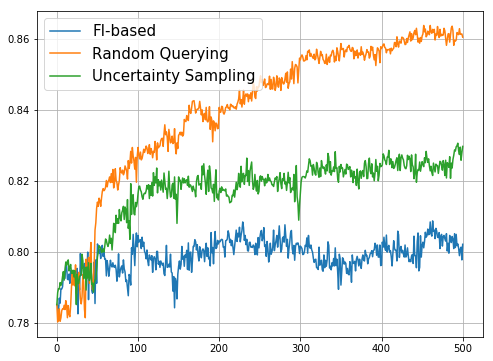

In [1086]:
plt.figure(figsize=(8,6))
plt.plot(fi_accs, label = 'FI-based')
plt.plot(rand_accs, label='Random Querying')
plt.plot(ent_accs, label='Uncertainty Sampling')
plt.legend(fontsize=15)
plt.grid()

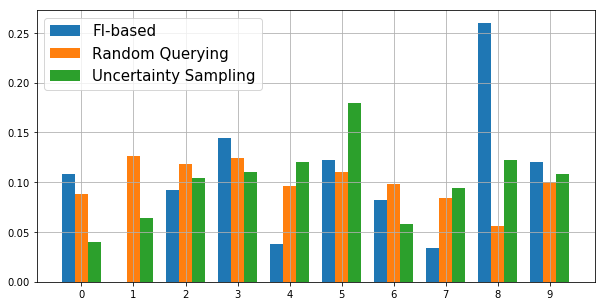

In [1083]:
fi_bins = np.histogram(fi_added_labels)[0]/500
rand_bins = np.histogram(rand_added_labels)[0]/500
ent_bins = np.histogram(ent_added_labels)[0]/500

plt.figure(figsize=(10,5))
plt.bar(np.arange(10)-.25,fi_bins, width=.25, label='FI-based')
plt.bar(np.arange(10),rand_bins, width=.25, label='Random Querying')
plt.bar(np.arange(10)+.25,ent_bins, width=.25, label='Uncertainty Sampling')
plt.xticks(np.arange(10))
plt.legend(fontsize=15)
plt.grid()

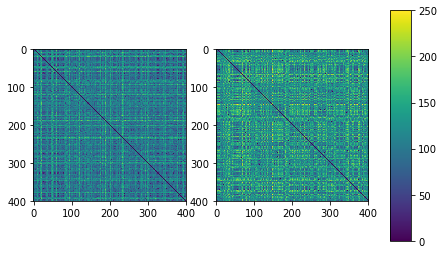

In [918]:
iters = 400
dist_map_rand = np.zeros((iters,iters))
dist_map_fi = np.zeros((iters,iters))

fi_condat = np.concatenate(fi_data, axis=1)
rand_condat = np.concatenate(rand_data, axis=1)

for i in range(iters):
    for j in range(iters):
        dist_map_rand[i,j] = np.sum((rand_condat[:,i] - rand_condat[:,j])**2)
        dist_map_fi[i,j] = np.sum((fi_condat[:,i] - fi_condat[:,j])**2)

fig, axes = plt.subplots(nrows=1, ncols=2)
im = axes[0].imshow(dist_map_rand, vmin=0, vmax=250)
im = axes[1].imshow(dist_map_fi, vmin=0, vmax=250)

cax = fig.add_axes([0.95, 0.1, 0.05, 0.8])
fig.colorbar(im,cax)